# Assignment02: Classifier Performance via Closure Test
> Kevin Liguori<br>
> Created: 09/11/25 <br>

## Introduction
In the notebook `tutorial02`, we built a simple classifier that approximated the **discriminant**, 
$$D(x) = \frac{p(x|1)}{p(x|1) + p(x|0)},$$ 
to classify the points $x \in \mathbb{R}^2$ sampled from a Gaussian mixture density. In notebook `tutorial02_metrics`, the quality of the classifier was evaluated using the **Receiver Operating Characteristic** (ROC) curve and the **Area Under the (ROC) Curve** (AUC). Notebook `tutorial02_test` compares the exact contours of given fixed values of $D(x)$ with the corresponding model approximations. 

In this notebook, you will check the quality of the classifier using a method that entails weighting *all* the test data. Given a dataset with probability density $d(x) = s(x) + b(x)$, where $s(x) \equiv p(1|x)$ and $b(x) \equiv p(0|x)$, you will weight each point of the test data with the weight $w(x) = D(x)$. The points sampled from $s(x)$ will be referred to as **signal**, while those sampled from $b(x)$ will be called the **background**. (If, for example, we were building a spam filter the signal would be the spam emails while the background would be the non-spam emails.)

Weighting points in a dataset morphs the associated density $d(x)$ to the density $d_w(x) = w(x) \, d(x)$. When applied to the problem at hand, we find
\begin{align}
    d_w(x) & = w(x) \, d(x), \\
           & = \frac{s(x)}{s(x)+b(x)} \, d(x),\\
           & = s(x) .
\end{align}
Therefore, if our model accurately approximates $D(x)$, weighting every point in the test data by $w(x)$ should yield points whose probability density $d_w(x)$ matches that of the signal,  $s(x)$. Any procedure that predicts a density that ought to match another is called a **closure test**. 

In this assignment you will
  1. Load the `test_data` into memory.
  2. Isolate the points corresponding to the signal, that is, points with $Y > 0.5$.
  4. Bin the signal points using a KD-tree (see below) and produce an ordered array of estimated signal probability densities, where the density is given by **bin count / bin volume / total count**.
  5. Using the same KD-tree, bin *all* test_data points $x \in X$ weighted by $w(x)$ and produce a second array of estimated probability densities in the same bin order as the first so that a bin-by-bin comparison between the two arrays can be performed.
  6. Visually compare the two arrays of densities using a plot. 

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# for reloading previously imported Python modules
import importlib

# for loading serialized Python objects
import joblib

# ML in physics module
import mlinphysics.nn as mlp
import mlinphysics.utils.data as dat
import mlinphysics.utils.kdtree as kdt

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn OFF if the system can't find LaTex
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

## Constants

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(DEVICE):4s}')

BASE = '../../Lab02' # location of model gauss2d

# add path to ../../Lab02/code to sys.path so that Python modules in 
# BASE/code can be imported
sys.path.append(f'{BASE}/code')

# file containing parameters of trained gauss2d model
params_file = f'{BASE}/code/gauss2d_params.pth' 

Available device: cpu 


## Import trained `gauss2d` model

In [3]:
import gauss2d
importlib.reload(gauss2d) # will reload gauss2d if this cell is re-executed

model = gauss2d.model
model.load(params_file)

print(model)
print('number of parameters', mlp.number_of_parameters(model))

Gauss2D(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): SiLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): SiLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): SiLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
number of parameters 541


## Load test data
The test data were saved in notebook `tutorial02.ipynb`. $X$ are the points and $Y$ are the labels.

DataLoader
  maxiter:               1
  batch_size:        17000
  shuffle_step:          1

Y.shape (squeezed): torch.Size([17000])


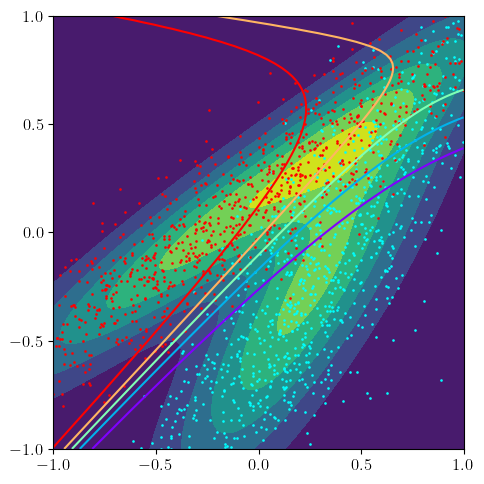

In [4]:
test_data_file = f'{BASE}/data/test_data.pth' 

test_data = joblib.load(test_data_file)

test_loader = dat.DataLoader(test_data, 
                             batch_size=len(test_data))

test_loader.reset()
X, Y = next(test_loader)

# remove last dimension from Y: (n, 1) => (n, )
Y = Y.squeeze()
print('Y.shape (squeezed):', Y.shape)

# plot test data

from exactdensity import ExactDensity
fexact = ExactDensity()
df = pd.DataFrame({'x1': X[:,0], 'x2': X[:, 1], 'y': Y})
fexact.plot(dataframe=df)

## Isolate signal points from `test_data`

The signal points are those labeled $y = 1$.

In [5]:
signal = X[Y > 0.5].detach().numpy() # convert from tensor to numpy array

print('number of signal points:', len(signal))

number of signal points: 8507


## Bin signal data using a KD-tree

Suppose we have $n$ points $\in \mathbb{R}^m$ that we wish to bin in $m$-D boxes. One way to do this is to use a data structure called a KD-tree. The latter can be visualized as a histogram in which the bins (i.e., leaves) are constructed by splitting each bin in two, such that each child bin has equal (or near equal) numbers of points. The algorithm is recursive in that the binary partitioning is applied to each of the two child bins of the parent and continues until the number of points in a given bin is $\le$ the desired bin (leaf) count. The bin is then referred to as a **leaf**. The algorithm is called **recursive binary partitioning** and is described informally below.

**Algorithm**
  1. Start with an $m$-D box (bin) containing all the points.
  2. Choose a dimension (`axis` in `numpy` jargon) from the sequence [0, 1,...m-1, 0, 1,....] along which to split the current bin. (The dimension chosen depends on the depth of the parent bin within the tree.)
  4. If the count in the current bin $\le$ the desired leaf count do not split the bin and call it a `leaf`, otherwise split the bin into two child bins and apply steps 2. and 3. to each child bin.
  5. Continue until all leaves have been constructed.

**Note**: The method `get_leaves()` of the class `KDTree` returns a list of leaves in *descending order* of estimated probability density.

A `leaf` of a `KDTree` object has the following attributes:
  1. ID: int - leaf identifier (ID = 0 for first leaf, ID = len(leaves)-1 for last leaf)
  1. points: (n, m)-ndarray - points in leaf
  2. bounds: (m, 2)-ndarray - limits of bounding box
  3. volume: float - volume of bounding box
  4. density: float - estimated probability density

In [6]:
importlib.reload(kdt) # will reload kdt if this cell is re-executed

# Note: the leaf count will be exactly equal to M if we choose
# the number of signal points and the leaf_count to be 
# powers of 2.

# pick off a signal sample with sample size equal to a power of 2
n_signal = 2**13
sig = signal[:n_signal] 

# make the desired leaf count also a power of 2
M = 2**7

# build the KD-tree using the sig sample
tree = kdt.KDTree(sig, leaf_size=M)

# return the leaves (aka, bins) of the tree
leaves = tree.get_leaves()

print('number of leaves (aka bins):', len(leaves))
print()

print('leaf with highest density')
print(leaves[0])
print()

print('leaf with lowest density')
print(leaves[-1])

number of leaves (aka bins): 64

leaf with highest density
leaf: 0
  number of points:        128
  density:           1.284e+00
  volume:            1.217e-02
        

leaf with lowest density
leaf: 63
  number of points:        128
  density:           4.142e-03
  volume:            3.772e+00
        


Given our choices for `n_signal` and `M`, all leaf counts should be identical. Check this.

In [7]:
print(f'{'leaf':>5s}\t{'count':5s} {'number density':>10s}')

for leaf in leaves:
    print(f'{leaf.ID:5d}\t{len(leaf.points):5d} {leaf.density:10.2e}')

 leaf	count number density
    0	  128   1.28e+00
    1	  128   1.11e+00
    2	  128   1.01e+00
    3	  128   9.32e-01
    4	  128   9.22e-01
    5	  128   9.08e-01
    6	  128   8.98e-01
    7	  128   8.88e-01
    8	  128   8.76e-01
    9	  128   8.73e-01
   10	  128   8.64e-01
   11	  128   8.51e-01
   12	  128   8.50e-01
   13	  128   8.15e-01
   14	  128   7.54e-01
   15	  128   7.26e-01
   16	  128   7.25e-01
   17	  128   7.23e-01
   18	  128   7.03e-01
   19	  128   7.01e-01
   20	  128   6.97e-01
   21	  128   6.86e-01
   22	  128   6.82e-01
   23	  128   6.47e-01
   24	  128   5.84e-01
   25	  128   5.79e-01
   26	  128   5.54e-01
   27	  128   5.31e-01
   28	  128   4.64e-01
   29	  128   4.50e-01
   30	  128   4.09e-01
   31	  128   4.07e-01
   32	  128   3.85e-01
   33	  128   3.52e-01
   34	  128   3.04e-01
   35	  128   2.70e-01
   36	  128   1.14e-01
   37	  128   9.90e-02
   38	  128   9.38e-02
   39	  128   9.11e-02
   40	  128   8.43e-02
   41	  128   8.37e-02
   42	 

### Plot KD-tree with $K = 2$

In [8]:
def plot_2dtree(leaves, points, 
                filename='2dtree.png', 
                xmin=-1, xmax=1, ymin=-1, ymax=1, 
                fgsize=(4.5, 4.4)):
    
    from matplotlib.patches import Rectangle

    # create a figure and add a single sub-plot
    fig = plt.figure(figsize=fgsize)
    nrows, ncols, index = 1, 1, 1
    ax  = fig.add_subplot(nrows, ncols, index)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
        
    tickmarks = np.linspace(xmin, xmax, 5)
    ax.set_xticks(tickmarks)
    ax.set_yticks(tickmarks)

    ax.set_xlabel('$x_1$', fontsize=18)
    ax.set_ylabel('$x_2$', fontsize=18)
    
    # normalize probability densities to interval [0, 1] 
    # so that each density corresponds to a color
    density     = [leaf.density for leaf in leaves]
    max_density = max(density)
    min_density = min(density)
    norm = colors.Normalize(vmin=min_density, vmax=max_density)

    # get desired colormap
    cmap = mp.colormaps['viridis']

    # loop over leaves and plot the bounding box of each leaf
    for leaf in leaves:
        
        (xmin, xmax), (ymin, ymax) = leaf.bounds
        xwidth = xmax - xmin
        ywidth = ymax - ymin

        # color bounding box of current leaf according to the density
        color = cmap(norm(leaf.density))
        rect = Rectangle((xmin, ymin), xwidth, ywidth, alpha=0.8, color=color)
        ax.add_patch(rect)

        # draw outline of bounding box
        ax.plot((xmin, xmax), (ymin, ymin), color='black', linewidth=0.5)
        ax.plot((xmax, xmax), (ymin, ymax), color='black', linewidth=0.5)
        ax.plot((xmax, xmin), (ymax, ymax), color='black', linewidth=0.5)
        ax.plot((xmin, xmin), (ymax, ymin), color='black', linewidth=0.5)

    # plot points
    x = points[:, 0]
    y = points[:, 1]
    ax.scatter(x, y, s=1, color='cyan')
    
    fig.tight_layout()
    
    plt.savefig(filename)
    plt.show()

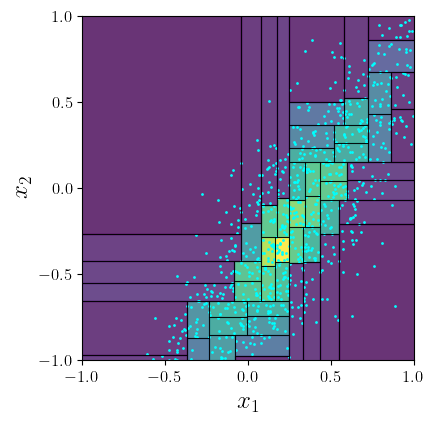

In [9]:
plot_2dtree(leaves, signal[:1000])

## Exercise
**Note**: The 2D tensor of points $X$ and their associated labels $Y$ were extracted from `test_data` in a previous cell. **NB**: $X$ includes points from both signal and background.

(**15 points**)

 1. Using the model trained in `tutorial02`, compute $D(x)$ for *all* points $x \in X$ in  `test_data`. These values will be the weights $w(x)$, one for each point. Note that the shape of the tensor returned by the model is (n, 1), where n is the number of points since $X$ is a tensor of shape (n, 2). Therefore, you will need to `squeeze()` away dimension 1: `w = model(X).squeeze()` to change the shape from (n, 1) to (n, ), that is, to a 1D tensor. (If you need to change the tensor to a numpy array, do `w = w.detach().numpy()`.)
 2. From the `leaves` object, create a numpy array `S` of the probability densities of the signal.
 3. Using the method `find_leaf(x)` of object `tree` (which returns the leaf into which the point $x$ falls) create a numpy array $W$ of length `len(leaves)` in which each bin contains the summed weights of all points $x \in X$ that fall in that leaf. (*Hint*: to create a numpy array of length `len(leaves)`, initialized to zero, do `W = np.zeros(len(leaves))`.) A leaf is identified by its leaf identifier, the attribute, ID. Identifiers go from 0 for the leaf with the highest density to len(leaves)-1 for the leaf with the lowest density.
 4. Normalize $W$ so that the latter contains probability densities. (See Introduction for how this is done for the signal densities.) 
 5. Create a plot that compares the two arrays of densities.

**Optional** (**5 points**)
 Search the internet, or consult ChatGPT, for a statistical procedure to test whether the two arrays of densities are the same within statistical uncertainties. How would you account for the fact that there are statistical uncertainties in all the estimated densities?


### Problem 1

We apply the model to all of the data to get the weights.

In [10]:
w = model(X).squeeze()

### Problem 2
We get the sigal density for each leaf. Note that if we sum the density * volume of each leaf, we should get 1.

In [11]:
S = np.array([lf.density for lf in leaves])
sum(np.array([S[i] * leaves[i].volume for i in range(len(leaves))])) == 1

np.True_

### Problem 3
Here we loop over all of the points in our dataset, find which leaf that point belongs to, and add the weight for that point to the running total for that leaf. Once we have gone through all of the points, we will have aggregated the total weight of each leaf. As a check here, we should have $$\sum_{\ell \in {\cal L}} W_\ell - \sum_{x \in X} w_x = 0,$$ with ${\cal L}$ the set of leaves. This is not the case, but very close, could maybe be numerics? I haven't had a change to investigate...

In [12]:
W = np.zeros(len(leaves))
for i in range(X.shape[0]):
    pt = X[i, :]
    leaf_id = tree.find_leaf(pt).ID
    W[leaf_id] += w[i]
print(sum(W) - sum(w))

tensor(-0.0107, grad_fn=<RsubBackward1>)


### Problem 4
Here we normalize the W distribution so that the sum of density * volume is 1, as above. I used chatGPT to find the normalization part of the code in your KD code so I could see how you were doing it. Again, not exactly one, could be because I used w instead of W to normalize, and we know there is a slight difference even though there shouldn't be (see above). I can't use W because it is getting overwritten so the answer would not be correct. 

In [13]:
for i in range(len(leaves)):
    W[i] = W[i] / leaves[i].volume / sum(w)
sum(np.array([W[i] * leaves[i].volume for i in range(len(leaves))]))

np.float64(0.9999987197534452)

### Problem 5
Here we plot the two distributions. Visually, the distributions seem very close. I used chatGPT to get some of the code to plot.

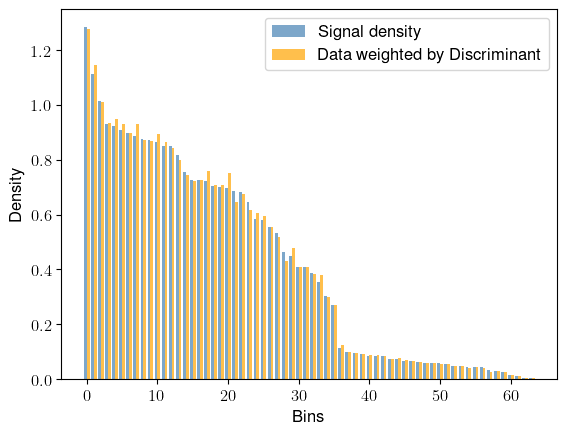

In [14]:
bins = np.arange(len(S))
width = 0.4  # bar width
plt.bar(bins - width/2, S, width=width, alpha=0.7, color='steelblue', label='Signal density')
plt.bar(bins + width/2, W, width=width, alpha=0.7, color='orange', label='Data weighted by Discriminant')
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend()

### Optional Part
Here we apply a statistical test to check if the two densities are the same. Note: I think we can use a $\chi^2$ test, and chatGPT seems to agree. I am a little apprehensive though since the expected number of points per bin for the signal is constant across all bins so I don't know if that will effect the test. But I figure since the weights per bin aren't apriori constant, I guess it should work?

The null hypothesis we are testing is that the the two densities are sampled from the same underlying distribution (i.e. they are the same statistically). We got a p-value $\gt 0.999$, thus we fail to reject the null hypothesis at the $\alpha = 0.001$ level, or really any reasonable level since $p \approx 1$.

In [15]:
from scipy.stats import chi2

num_S = n_signal
num_W = len(X)
nS = np.array([S[i] * leaves[i].volume * num_S for i in range(len(S))]) # Expected number of points per bin for signal set
nW = np.array([W[i] * leaves[i].volume * num_W for i in range(len(W))]) # Expected number of points per bin for all data
E = (nS + nW) / (num_S + num_W)

dof = len(nS) - 1
chi2_statistic = sum((nS - num_S * E)**2 / (num_S * E) + (nW - num_W * E)**2 / (num_W * E)) 
p_value = 1 - chi2.cdf(chi2_statistic, dof)
print("p-value: ", p_value)

p-value:  0.9999999999348681


Note: I did some collaboration with chatGPT on this assignment. I tried to explicitly mention where. 